In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from templates import *

In [3]:
device = 'cuda:0'
conf = ffhq256_autoenc()
# print(conf.name)
model = LitModel(conf)
state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

Global seed set to 0


Model params: 160.69 M


In [4]:
img_dir = 'imgs_align'
for i,file in enumerate(os.listdir(img_dir)):
    print(f'{i}: {file}')

0: idPhoto.png
1: megane.png
2: sample01.png
3: sandy.png
4: women_default.png
5: yotaka_default.png
6: yotaka_smile.png


In [7]:
data = ImageDataset(img_dir, image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
batch = torch.stack([
    data[5]['img'],
    data[6]['img'],
])

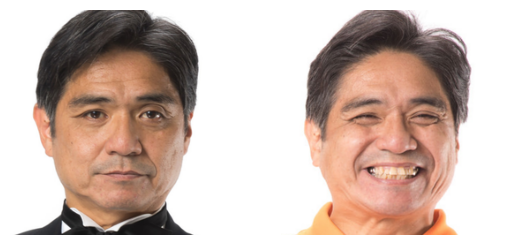

In [8]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,2)
for i in range(len(ax)):
    ax[i].axis('off')
ax[0].imshow(batch[0].permute([1,2,0])/2+0.5)
ax[1].imshow(batch[1].permute([1,2,0])/2+0.5)
plt.show()

In [9]:
cond = model.encode(batch.to(device))
xT = model.encode_stochastic(batch.to(device), cond, T=250)

## Interpolate

Semantic codes are interpolated using convex combination, while stochastic codes are interpolated using spherical linear interpolation.

In [10]:
import numpy as np
alpha = torch.tensor(np.linspace(0, 1, 60, dtype=np.float32)).to(cond.device)
# alpha[:, None] = alpha.unsqueeze(dim=1)
intp = cond[0][None] * (1 - alpha[:, None]) + cond[1][None] * alpha[:, None]

def cos(a, b):
    a = a.view(-1)
    b = b.view(-1)
    a = F.normalize(a, dim=0)
    b = F.normalize(b, dim=0)
    return (a * b).sum()

theta = torch.arccos(cos(xT[0], xT[1]))
x_shape = xT[0].shape
intp_x = (torch.sin((1 - alpha[:, None]) * theta) * xT[0].flatten(0, 2)[None] + torch.sin(alpha[:, None] * theta) * xT[1].flatten(0, 2)[None]) / torch.sin(theta)
intp_x = intp_x.view(-1, *x_shape)

preds = []
for i in range(len(intp)):
    pred = model.render(intp_x[i][None], intp[i][None], T=20)
    preds.append(pred[0])

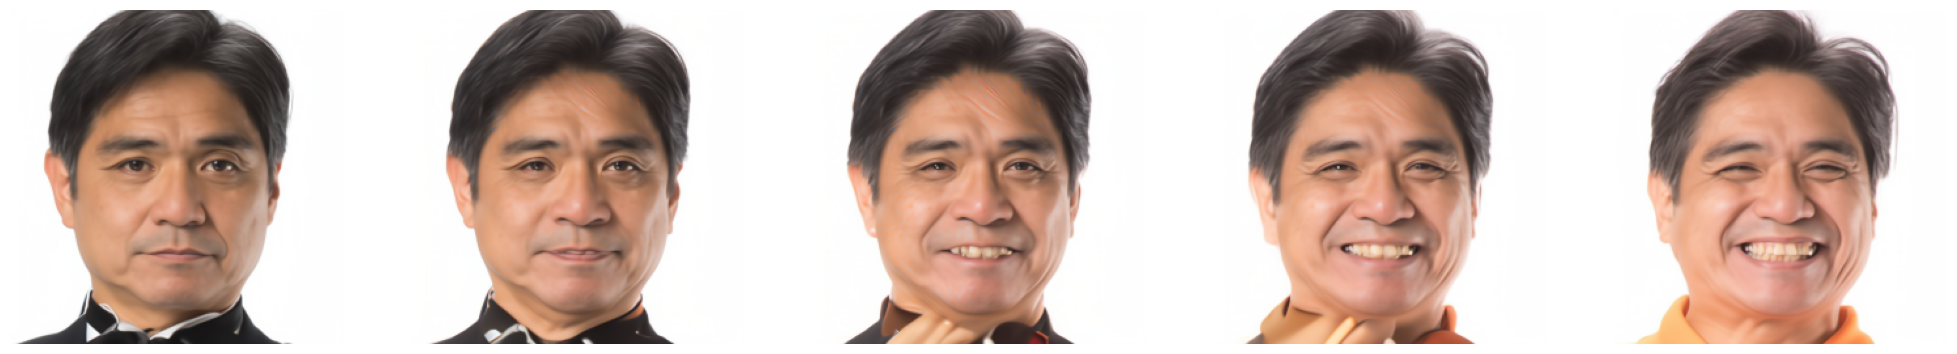

In [11]:
import matplotlib.pyplot as plt

num_show = 5
fig,ax = plt.subplots(1,num_show, figsize=(5*num_show, 5))
for i,j in enumerate(np.linspace(0,len(preds)-1,num_show,dtype=np.uint8)):
    ax[i].imshow(preds[j].permute(1,2,0).cpu())
    ax[i].axis('off')

## gifの保存

In [20]:
from PIL import Image

preds_pil = []
for p in preds:
    p_np = np.array((p*255).permute(1,2,0).cpu()).astype(np.uint8)
    preds_pil.append(Image.fromarray(p_np))

In [21]:
dst_dir = "imgs_test/imgs_interpolate/"
file_name = "yotaka2smile.gif"
if not os.path.exists(dst_dir):
    os.mkdir(dst_dir)
dst_path = dst_dir + file_name

preds_pil[0].save(
    dst_path,
    format="gif",
    save_all=True,
    append_images=preds_pil,
    duration=33,
    loop=0,
)

## 静止画像の保存

In [32]:
from torchvision.utils import save_image

index = 59
dst_dir = "imgs_test/imgs_interpolate/"
file_name = "yotaka2smile_%02d.png" % index
dst_path = dst_dir + file_name
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)

save_image(preds[index], dst_path)